# Experimenting The Bayesian Way

### A/B experiments : 
Two popular approaches to measuring the differences between theses variants statistically: 
* **the frequentist approach** : In this approach, you treat the traffic in each variant as a sample of all the traffic you will get in your website’s lifetime. Since we are dealing with samples, the means of the samples can be equal or different due to chance — hence, we must use statistical tests (such as Student t-test), confidence intervals, and p-values to figure out whether this is the case. The difference is statistically significant if we can prove that it is unlikely to be due to chance. If you are taking a frequentist approach, you will have to wait until you collect a certain amount of data before you can determine if a change is statistically significant.

* **the Bayesian approach** : if we use a Bayesian approach, we must think more in terms of beliefs. The probabilities we see in our samples are interpreted as beliefs about how different the two variants are. Beliefs can be initialized using our prior knowledge of our website visitors and updated using data. Rather than discussing whether the difference between the two samples is significant or not, we quantify our beliefs about how different the two samples are.

## Beta distribution 

The beta function takes two parameters, alpha (the number of successful penalty kicks) and beta (the number of missed penalty kicks).

We are asking Player A to make eight kicks, and then another eight, and then another, all the way up to 10,000 sets of eight kicks. Similarly, for Player B, we are asking him to make 10,000 sets of 85 kicks. Then, we’ll compare the distributions of their penalty kick accuracies.

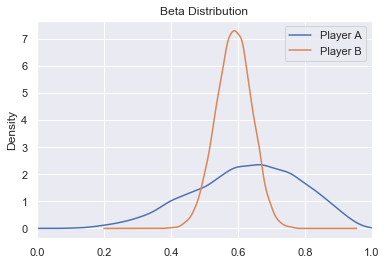

In [7]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

from numpy.random import beta

# How many random samples to generate
N = 10000

# We define alpha and beta for the two distributions
success_a = 5
failure_a = 3
success_b = 50
failure_b = 35

# Generate N samples using the predefined alphas and betas
a_samples = beta(success_a, failure_a, N)
b_samples = beta(success_b, failure_b, N)

# Convert to a Pandas Series for better handling later
a_samples = pd.Series(a_samples)
b_samples = pd.Series(b_samples)

# Plot the two distributions using kernel density estimation
pd.DataFrame(
    {
        'Player A': a_samples,
        'Player B': b_samples,

    }
).plot(
    kind='kde',
    title='Beta Distribution',
    xlim=(0,1),
);

According to the distribution means, Player A is slightly better than Player B on average. However, the orange distribution is narrower, which means that we have more confidence that Player B’s accuracy is somewhere above 40% and below 80%, while Player A’s accuracy is all over the place (it can be 20% or even 100%; we're not sure). Obviously, Player A’s accuracy is more likely to be above 60% based on his bigger probability mass
>When both alpha and beta equal one, we end up with a uniform distribution

## Binomial distribution 

Say we know that a player has a penalty kick accuracy of 80%. If he shoots 10 penalty kicks in a row, what are the chances that he will score only one out of all of them? What about the chances of only scoring two or three, and so on? 

Since this is a discrete distribution, we represent it with a probability mass function instead of a probability density function. As you can see, the graph is displayed as discrete bars and — since probabilities should add up to one — the sum of the bars’ heights for each player add up to one.

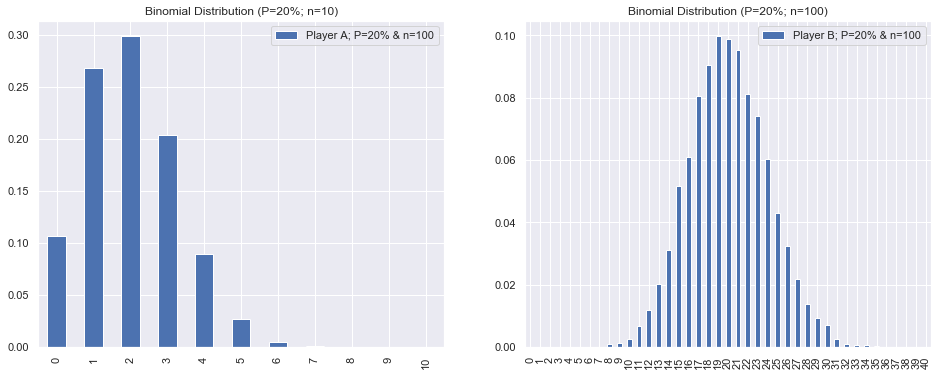

In [9]:
from numpy.random import binomial

# How many random samples to generate
N = 10000

# Binomial distribution parameters
n_a = 10
p_a = 0.2
n_b = 100
p_b = 0.2

# Generate N samples using the predefined N and p
a_samples = binomial(n_a, p_a, N)
b_samples = binomial(n_b, p_b, N)

# Convert to a Pandas Series for better handling later
a_samples = pd.Series(a_samples)
b_samples = pd.Series(b_samples)

# We get some values around 2 in the A samples
# And some values around 20 in the B sample
# We want to calculate how often each value appears
a_freq = a_samples.value_counts()
b_freq = b_samples.value_counts()

# For better visualisation
# We will pad some of missing frequencies
# We will set them to zero
a_freq = a_freq.reindex(range(11), fill_value=0)
b_freq = b_freq.reindex(range(41), fill_value=0)

# Sine we are calculating probabilities here
# We will divide by the total number of samples (N)
a_hist = a_freq / N
b_hist = b_freq / N

fig, axs = plt.subplots(1, 2, figsize=(16,6))

# We already calculated our histogram,
# So we will use a bar chart here instead.
pd.DataFrame(
    {
        'Player A; P=20% & n=100': a_hist,
    }
).plot(
    kind='bar',
    title='Binomial Distribution (P=20%; n=10)',
    xlim=(0, 10),
    ax=axs[0],
)


pd.DataFrame(
    {
        'Player B; P=20% & n=100': b_hist,
    }
).plot(
    kind='bar',
    title='Binomial Distribution (P=20%; n=100)',
    xlim=(0, 50),
    ax=axs[1],
);

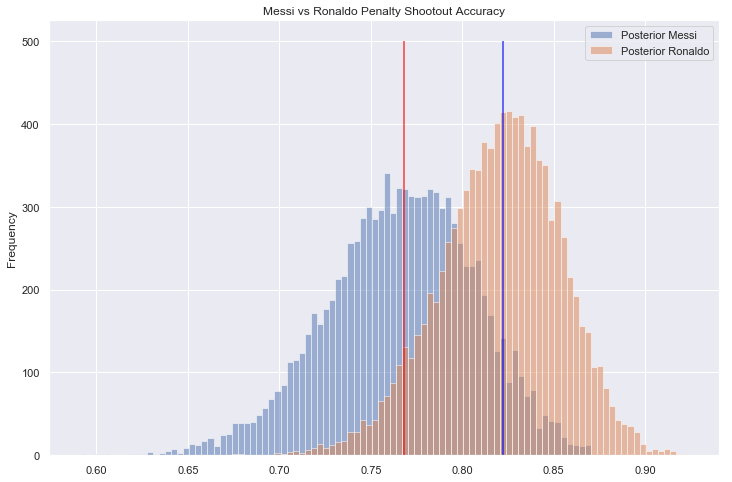

In [11]:
from numpy.random import binomial
from numpy.random import beta

# Our priors Beta distribution parameters
prior_alpha = 1
prior_beta = 1

# How many kicks were scored
successes_messi = 81
successes_ronaldo = 109

# How many kicks were not scored
fails_messi = 24
fails_ronaldo = 23

# Calculate Posterior := Likelihood * Prior
messi_samples = beta(
    a = prior_alpha + successes_messi,
    b = prior_beta + fails_messi,
    size=10000
)
ronaldo_samples = beta(
    a = prior_alpha + successes_ronaldo,
    b = prior_beta + fails_ronaldo,
    size=10000
)

fig, ax = plt.subplots(1, 1, figsize=(12,8))

pd.DataFrame(
    {
        'Posterior Messi': messi_samples,
        'Posterior Ronaldo': ronaldo_samples,
    }
).plot(
    kind='hist',
    title='Messi vs Ronaldo Penalty Shootout Accuracy',
    bins=100,
    alpha=0.5,
    ax=ax,
)

# Add lines to show the medians of each distribution
ax.vlines(
    x=np.median(messi_samples), ymin=0, ymax=500, color='red', alpha=0.75,
)

ax.vlines(
    x=np.median(ronaldo_samples), ymin=0, ymax=500, color='blue', alpha=0.75,
);

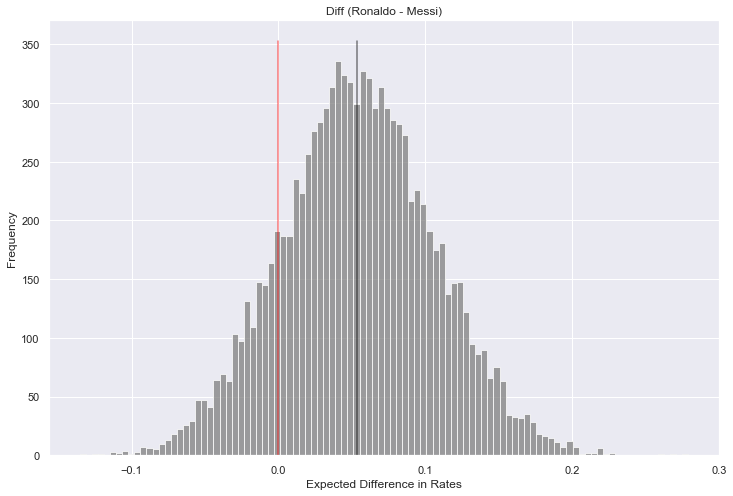

In [12]:
# Calculate the difference between the two samples
samples_diff = pd.Series(ronaldo_samples) - pd.Series(messi_samples)

# Find the median of the difference
samples_diff_median = samples_diff.median()

fig, ax = plt.subplots(1, 1, figsize=(12,8))

# Plot the samples difference
samples_diff.plot(
    kind='hist',
    title='Diff (Ronaldo - Messi)',
    bins=100,
    color='Gray',
    alpha=0.75,
    ax=ax,
)

ax.set_xlabel("Expected Difference in Rates")

# Draw a black line at the median of the difference
diff_vline_min, diff_vline_max = ax.get_ylim()
ax.plot(
    (samples_diff_median, samples_diff_median),
    (diff_vline_min, diff_vline_max),
    'Black',
    alpha=0.5,
)

# Draw a red line at zero
ax.plot(
    (0, 0),
    (diff_vline_min, diff_vline_max),
    'Red',
    alpha=0.5,
);

In [13]:
print(
    'Confidence that Ronaldo > Messi: {}%'.format(
        (
            100 * ((b_samples - a_samples) > 0).mean()
        ).round(2)
    )
)

print(
    'Difference (Ronaldo - Messi) Median {}%'.format(
        round(100 * samples_diff_median, 2)
    )
)

Confidence that Ronaldo > Messi: 100.0%
Difference (Ronaldo - Messi) Median 5.37%
